In [1]:
from runlmc.models.lmc import LMC
from runlmc.kern.rbf import RBF
from paramz.optimization import Optimizer
import numpy as np
import numdifftools
import scipy.optimize as sciopt

%matplotlib inline 
import matplotlib.pyplot as plt

np.random.seed(1234)


In [2]:
n_per_output = [65, 100]
xss = list(map(np.random.rand, n_per_output))
nout = len(n_per_output)
yss = [np.sin(2 * np.pi * xs + i * 2 * np.pi / nout)
       + np.random.randn(len(xs)) * (i + 1) * 0.1 / nout
       for i, xs in enumerate(xss)]
ks = [RBF(name='rbf{}'.format(i)) for i in range(nout)]

In [3]:
def print_diagram(lmc):
    plot_xs =  np.arange(0, 1, 0.01)
    ys, var = lmc.predict([plot_xs for _ in range(nout)])
    for i, (y, v, xs, ys) in enumerate(zip(ys, var, xss, yss)):
        sd = np.sqrt(v)
        order = xs.argsort()
        plt.scatter(xs[order], ys[order])
        plt.title('output {} (95%)'.format(i))
        plt.plot(plot_xs, y)
        plt.plot(plot_xs, y + 2 * sd, ls='--', c='g')
        plt.plot(plot_xs, y - 2 * sd, ls='--', c='g')
        plt.show()

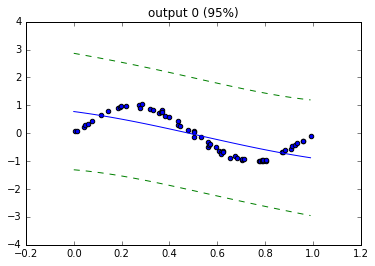

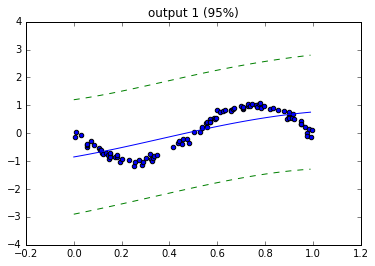

In [4]:
# Unoptimized
lmc = LMC(xss, yss, kernels=ks, normalize=False)
print_diagram(lmc)

In [5]:
import climin

class Opt(Optimizer):
    def __init__(self):
        super().__init__()

    def opt(self, x, f_fp=None, f=None, fp=None):
        ada = climin.Adadelta(x, fp, step_rate=1, decay=0.9, momentum=0.4, offset=0.0001)
        gn_cut = 1e-6 * len(x)
        print('Starting iteration. Will stop when grad norm reaches {}'.format(gn_cut))
        for info in ada:
            gn = np.linalg.norm(info['gradient'])
            if info['n_iter'] % 10 == 0:
                print('iteration', info['n_iter'], 'grad norm {:10.4e}'.format(gn))
            if info['n_iter'] >= 100 or gn < gn_cut:
                break
        print('Finished in {} iterations with l2 grad norm {}'
             .format(info['n_iter'], np.linalg.norm(info['gradient'])))
        self.x_opt = x
    
lmc.optimize(optimizer=Opt())

Starting iteration. Will stop when grad norm reaches 1.2e-05
iteration 10 grad norm 3.0568e+01
iteration 20 grad norm 4.6630e+01
iteration 30 grad norm 1.7317e+01
iteration 40 grad norm 1.0376e+01
iteration 50 grad norm 1.4084e+01
iteration 60 grad norm 5.8330e+00
iteration 70 grad norm 1.6545e+01
iteration 80 grad norm 2.0330e+01
iteration 90 grad norm 8.9200e+00
iteration 100 grad norm 7.8694e+00
Finished in 100 iterations with l2 grad norm 7.869405454440139



Name : lmc
Objective : -161.30158048000527
Number of Parameters : 12
Number of Optimization Parameters : 12
Updates : True
Parameters:
  lmc.                  |          value  |  constraints  |  priors
  rbf0.inv_lengthscale  |   2.8453463526  |      +ve      |        
  rbf1.inv_lengthscale  |  5.57251082354  |      +ve      |        
  a0                    |           (2,)  |               |        
  a1                    |           (2,)  |               |        
  kappa0                |           (2,)  |      +ve      |        
  kappa1                |           (2,)  |      +ve      |        
  noise                 |           (2,)  |      +ve      |        
  index  |     lmc.noise  |  constraints  |  priors
  [0]    |    0.00255797  |      +ve      |        
  [1]    |    0.00828975  |      +ve      |        


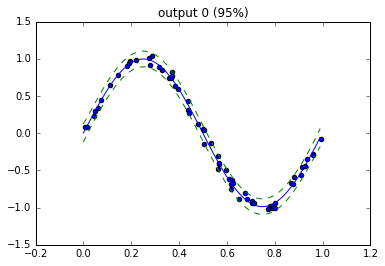

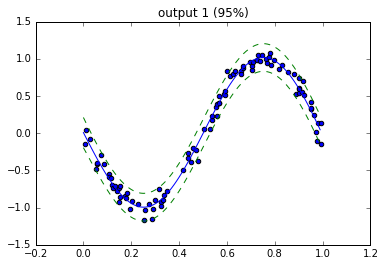

In [6]:
#optimized
print(lmc)
print(lmc.noise)
print_diagram(lmc)

In [7]:
import GPy

rbfs = [GPy.kern.RBF(1) for _ in range(nout)]
# not exactly the same since mine is rank-1 only for now
# This is why we need as many kernels as outputs, because we'd be rank-deficient o/w
k = GPy.util.multioutput.LCM(input_dim=1,num_outputs=nout,kernels_list=rbfs)
xss_reshaped = [xs.reshape(-1, 1) for xs in xss]
yss_reshaped = [ys.reshape(-1, 1) for ys in yss]
m = GPy.models.GPCoregionalizedRegression(
    xss_reshaped, yss_reshaped, kernel=k)
m.optimize()
print(m)


Name : gp
Objective : -180.1539844508099
Number of Parameters : 14
Number of Optimization Parameters : 14
Updates : True
Parameters:
  gp.                                    |              value  |  constraints  |  priors
  sum.ICM0.rbf.variance                  |   0.00727088800689  |      +ve      |        
  sum.ICM0.rbf.lengthscale               |     0.339676192353  |      +ve      |        
  sum.ICM0.B.W                           |             (2, 1)  |               |        
  sum.ICM0.B.kappa                       |               (2,)  |      +ve      |        
  sum.ICM1.rbf.variance                  |  1.55771150805e-11  |      +ve      |        
  sum.ICM1.rbf.lengthscale               |      13.8073142083  |      +ve      |        
  sum.ICM1.B.W                           |             (2, 1)  |               |        
  sum.ICM1.B.kappa                       |               (2,)  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |    0.0025068250749  | 

 /usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


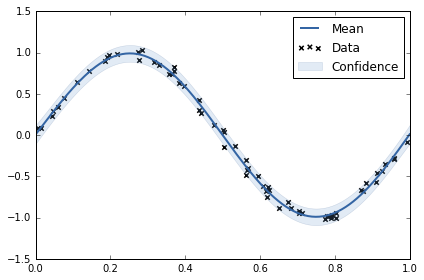

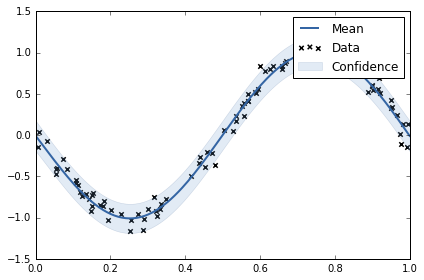

In [8]:
# Plotting code adapted from GPy coregionalization tutorial
# Also 95% confidence

data_rows = np.add.accumulate(n_per_output)
data_rows = np.insert(data_rows, 0, 0)

for i in range(nout):
    m.plot(
        plot_limits=(0, 1),
        fixed_inputs=[(1,i)],
        which_data_rows=slice(data_rows[i],data_rows[i + 1]))